In [1]:
import os
import glob
import argparse
import time
from PIL import Image
import numpy as np
import PIL

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from tensorflow.keras.models import load_model
from layers import BilinearUpSampling2D
from loss import depth_loss_function
from utils import predict, display_images
from matplotlib import pyplot as plt

# Argument Parser
parser = argparse.ArgumentParser(description='High Quality Monocular Depth Estimation via Transfer Learning')
parser.add_argument('--model', default='nyu.h5', type=str, help='Trained Keras model file.')
parser.add_argument('--input', default='my_examples/*.jpg', type=str, help='Input filename or folder.')
args, unknown = parser.parse_known_args()

# Custom object needed for inference and training
start = time.time()
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(args.model, custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format(args.model))

def load_images_with_resize(image_files):
    loaded_images = []
    for file in image_files:
        im = Image.open( file )
        im = im.resize((640, 480), PIL.Image.ANTIALIAS)
        x = np.clip(np.asarray(im, dtype=float) / 255, 0, 1)
        loaded_images.append(x)
    return np.stack(loaded_images, axis=0)

# Input images
inputs = load_images_with_resize( glob.glob(args.input) )
print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

# Compute results
outputs = predict(model, inputs)

end = time.time()
print('It took: ', end - start)

c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (

Loading model...
Instructions for updating:
Colocations handled automatically by placer.

Model loaded (nyu.h5).

Loaded (1) images of size (480, 640, 3).


c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\env\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


It took:  21.755815267562866


c:\Users\Henry Kaus\Desktop\Winter 2023\CS 410\Project\monocular_depth_estimation\utils.py:77: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return skimage.util.montage(all_images, multichannel=True, fill=(0,0,0))


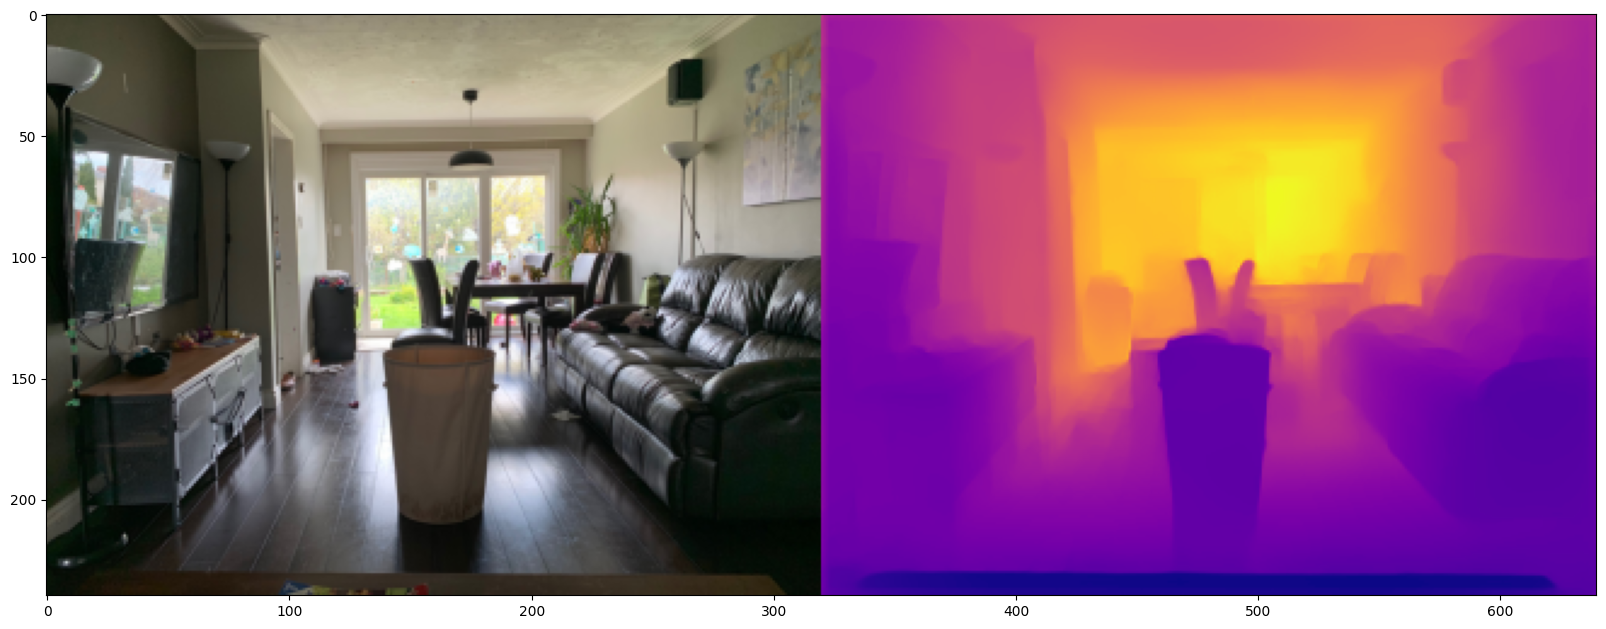

In [2]:
# Display results
viz = display_images(outputs.copy(), inputs.copy())
plt.figure(figsize=(20,10))
plt.imshow(viz)
#plt.savefig('results.png')